# Explainable AI using SHAP

#### Problem: Pedicting Customer Churn
#### Problem Type: Binary Classification 
#### Description: Given a set of features for customers of a bank predict whether they will churn or not (i.e., leave or stay)

##### Please note the emphasis of this notebook is to demonstrate the use of SHAP, so we will not be focusing on other aspects of ML such as EDA, Model Training & Optmization Process etc.

## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import shap
import pyintellify
import matplotlib.pyplot as plt
pyintellify.setmpl()

## Load Data

In [2]:
df = pd.read_csv('Churn_Modelling.csv')

In [3]:
display(df)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


### Checks

In [4]:
#Target Distribution - Imbalanced
df['Exited'].value_counts(normalize = True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

In [5]:
#Check for missing values
df.isnull().values.sum()

0

### Divide the features into categories

In [6]:
meta = ['RowNumber', 'CustomerId', 'Surname']

#Note I have dropped a few model input features for simplicity
model_features = ['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

## Feature Encoding

In [7]:
df['Gender'].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

In [8]:
def encode_gender(gender):
    if(gender == 'Female'):
        return 1
    else:
        return 0
    
df['Gender'] = df['Gender'].transform(lambda x: encode_gender(x))

In [9]:
df['Gender'].value_counts()

0    5457
1    4543
Name: Gender, dtype: int64

## Divide into train and test

In [10]:
train, test = train_test_split(df, stratify = df['Exited'], test_size = 0.20, random_state = 0)

In [11]:
train = train.reset_index(drop = True)
test = test.reset_index(drop = True)

In [12]:
display(train)
display(test)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,494,15725679,Hsia,531,France,1,47,6,0.00,1,0,0,194998.34,1
1,6840,15768282,Perez,724,Germany,0,36,6,94615.11,2,1,1,10627.21,0
2,171,15587562,Hawkins,484,France,1,29,4,130114.39,1,1,0,164017.89,0
3,4959,15594502,Zotov,655,France,0,37,6,109093.41,2,1,0,1775.52,0
4,4272,15707132,Yudin,465,France,0,33,5,0.00,2,0,1,78698.09,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,6728,15610416,Christie,745,France,1,36,9,0.00,1,1,0,19605.18,1
7996,4675,15689492,Benjamin,850,Germany,0,41,1,176958.46,2,0,1,125806.30,0
7997,6400,15738501,Booth,601,Germany,0,48,9,163630.76,1,0,1,41816.49,1
7998,873,15794549,Andrews,722,France,1,35,2,163943.89,2,1,1,15068.18,0


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1345,15691104,Kennedy,460,Germany,1,40,6,119507.58,2,1,0,91560.63,1
1,8168,15793135,Wang,713,Germany,1,24,7,147687.24,1,1,1,121592.50,0
2,4748,15702380,De Luca,663,Spain,0,64,6,0.00,2,0,1,15876.52,0
3,5005,15625092,Colombo,502,Germany,1,57,3,101465.31,1,1,0,43568.31,1
4,3125,15795224,Wu,760,France,0,39,6,178585.46,1,1,0,67131.30,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,9108,15617434,Yen,655,Spain,0,38,9,0.00,1,0,1,90490.33,0
1996,8250,15727421,Anayolisa,586,France,1,38,6,0.00,2,1,1,37935.83,0
1997,8338,15568519,Wood,534,France,0,41,9,0.00,2,1,0,13871.34,0
1998,6280,15608338,Chiemenam,757,Spain,1,55,9,117294.12,4,1,0,94187.47,1


In [13]:
X_train = train[model_features]
y_train = train['Exited']

X_test = test[model_features]
y_test = test['Exited']

## Model Training

In [14]:
clf = RandomForestClassifier(n_estimators = 150, criterion = 'entropy', max_depth = 6, bootstrap = True, 
                             random_state = 42)

In [15]:
clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=6, n_estimators=150,
                       random_state=42)

#### Model Stats

In [16]:
#Training accuracy
print(classification_report(y_train, clf.predict(X_train)))

              precision    recall  f1-score   support

           0       0.87      0.98      0.92      6370
           1       0.82      0.42      0.56      1630

    accuracy                           0.86      8000
   macro avg       0.84      0.70      0.74      8000
weighted avg       0.86      0.86      0.84      8000



In [17]:
#Test accuracy
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.97      0.91      1593
           1       0.78      0.37      0.50       407

    accuracy                           0.85      2000
   macro avg       0.82      0.67      0.71      2000
weighted avg       0.84      0.85      0.83      2000



##### Since this is an imbalanced problem we are more focused on the F1 on minority class. The results are okayish given we have done no optimization - we can live with that for now.

## SHAP

In [18]:
#Not providing a backgroud dataset here explicitly, so SHAP goes down the tree splits to get background.
explainer = shap.TreeExplainer(clf)

In [19]:
shap_values = explainer.shap_values(X_train)

In [20]:
shap_values

[array([[-6.53368538e-03, -3.26681366e-02, -2.47634217e-01, ...,
         -8.87585258e-04, -8.61363414e-02, -1.17648944e-02],
        [ 2.03954213e-03,  1.53126484e-02,  5.96573537e-02, ...,
          4.26905410e-04,  2.60290141e-02,  1.20322995e-03],
        [ 1.14041231e-04, -2.14727697e-02,  1.27569594e-01, ...,
          3.81282657e-04, -3.78219682e-02, -3.68158619e-03],
        ...,
        [-4.66817896e-04,  2.53696329e-02, -1.82744703e-01, ...,
         -2.16306241e-03,  8.03002294e-02,  1.13497830e-03],
        [ 1.86289780e-03, -1.91768422e-02,  6.80369477e-02, ...,
          2.23451037e-04,  2.83148272e-02, -3.48835419e-05],
        [ 2.57798659e-03,  1.34057878e-02,  8.60957634e-02, ...,
          2.63782968e-04, -2.83778731e-02, -4.61518906e-04]]),
 array([[ 6.53368538e-03,  3.26681366e-02,  2.47634217e-01, ...,
          8.87585258e-04,  8.61363414e-02,  1.17648944e-02],
        [-2.03954213e-03, -1.53126484e-02, -5.96573537e-02, ...,
         -4.26905410e-04, -2.60290141e

### The two arrays you see above are for two different views
1) First - From the point of view of not churning

2) Second - From the point of view of churning (This is what we care about in this notebook since we are predicting the probability of churn)

In [21]:
#8000 -> Total Customers in X_train and 9 -> Total Features
shap_values[1].shape

(8000, 9)

In [22]:
explainer.expected_value

array([0.79660333, 0.20339667])

### As seen above, from the data passed to the ML model, 80% don't churn while 20% churn

### Global Plots

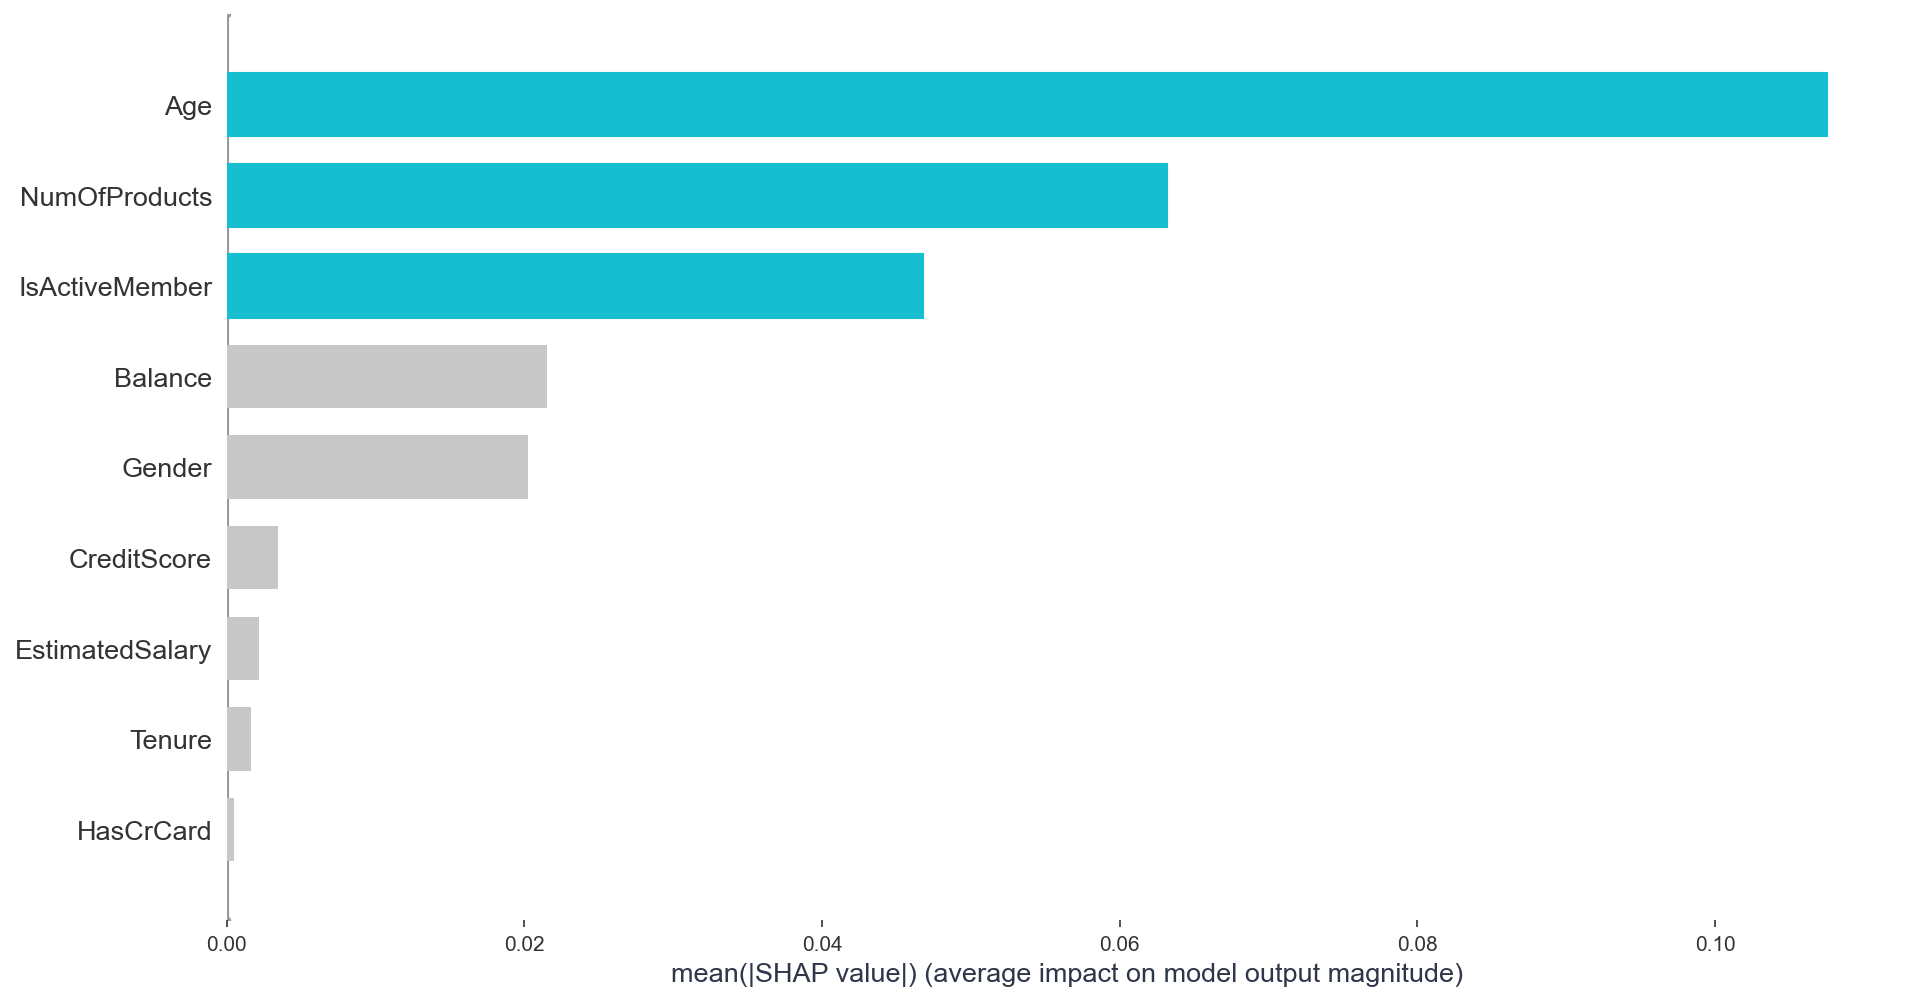

In [23]:
#Feature Importance
shap.summary_plot(shap_values[1], X_train, plot_type = "bar", color = pyintellify.tableau21[18], show = False)
fig = plt.gcf()
fig.set_figheight(8)
fig.set_figwidth(14)
ax = plt.gca()
plt.xticks(fontsize = 10)
ax.spines['bottom'].set_visible(False)
ax.get_children()[6].set_color(pyintellify.tableau21[5])
ax.get_children()[7].set_color(pyintellify.tableau21[5])
ax.get_children()[8].set_color(pyintellify.tableau21[5])
plt.show()

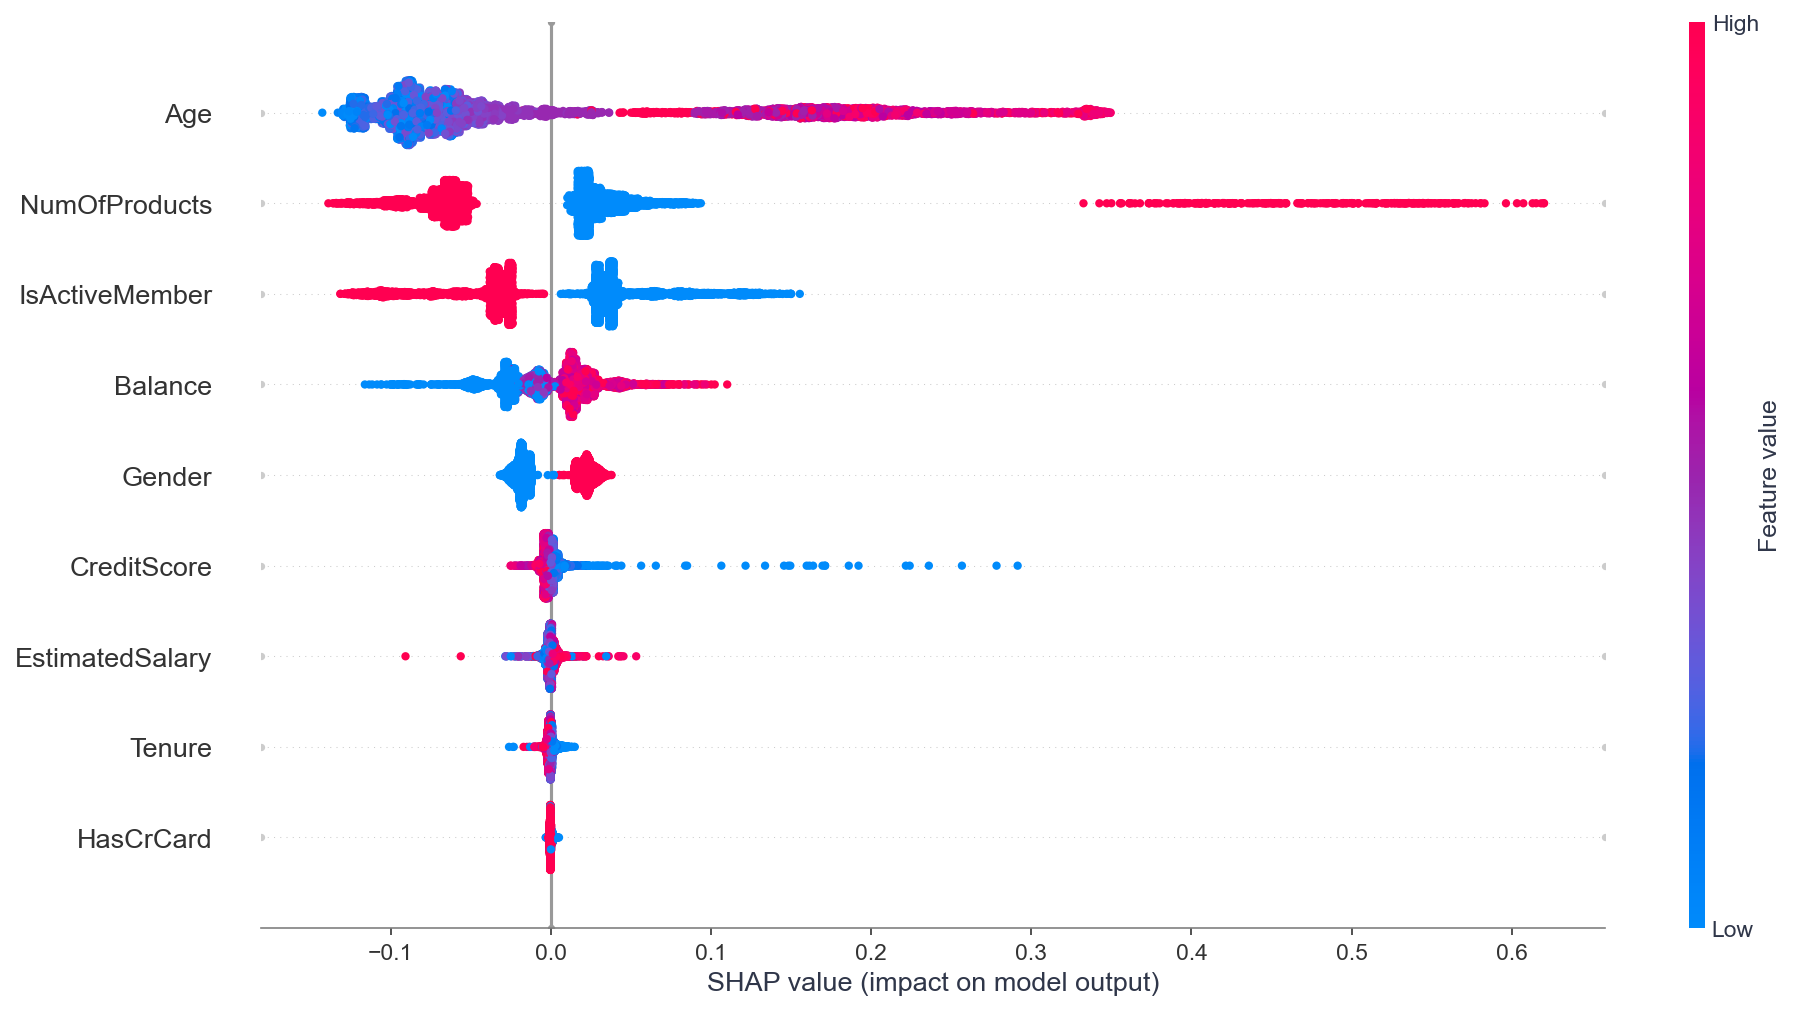

In [24]:
shap.summary_plot(shap_values[1], X_train, color = pyintellify.tableau21[5], show = False)
fig = plt.gcf()
fig.set_figheight(8)
fig.set_figwidth(14)
ax = plt.gca()

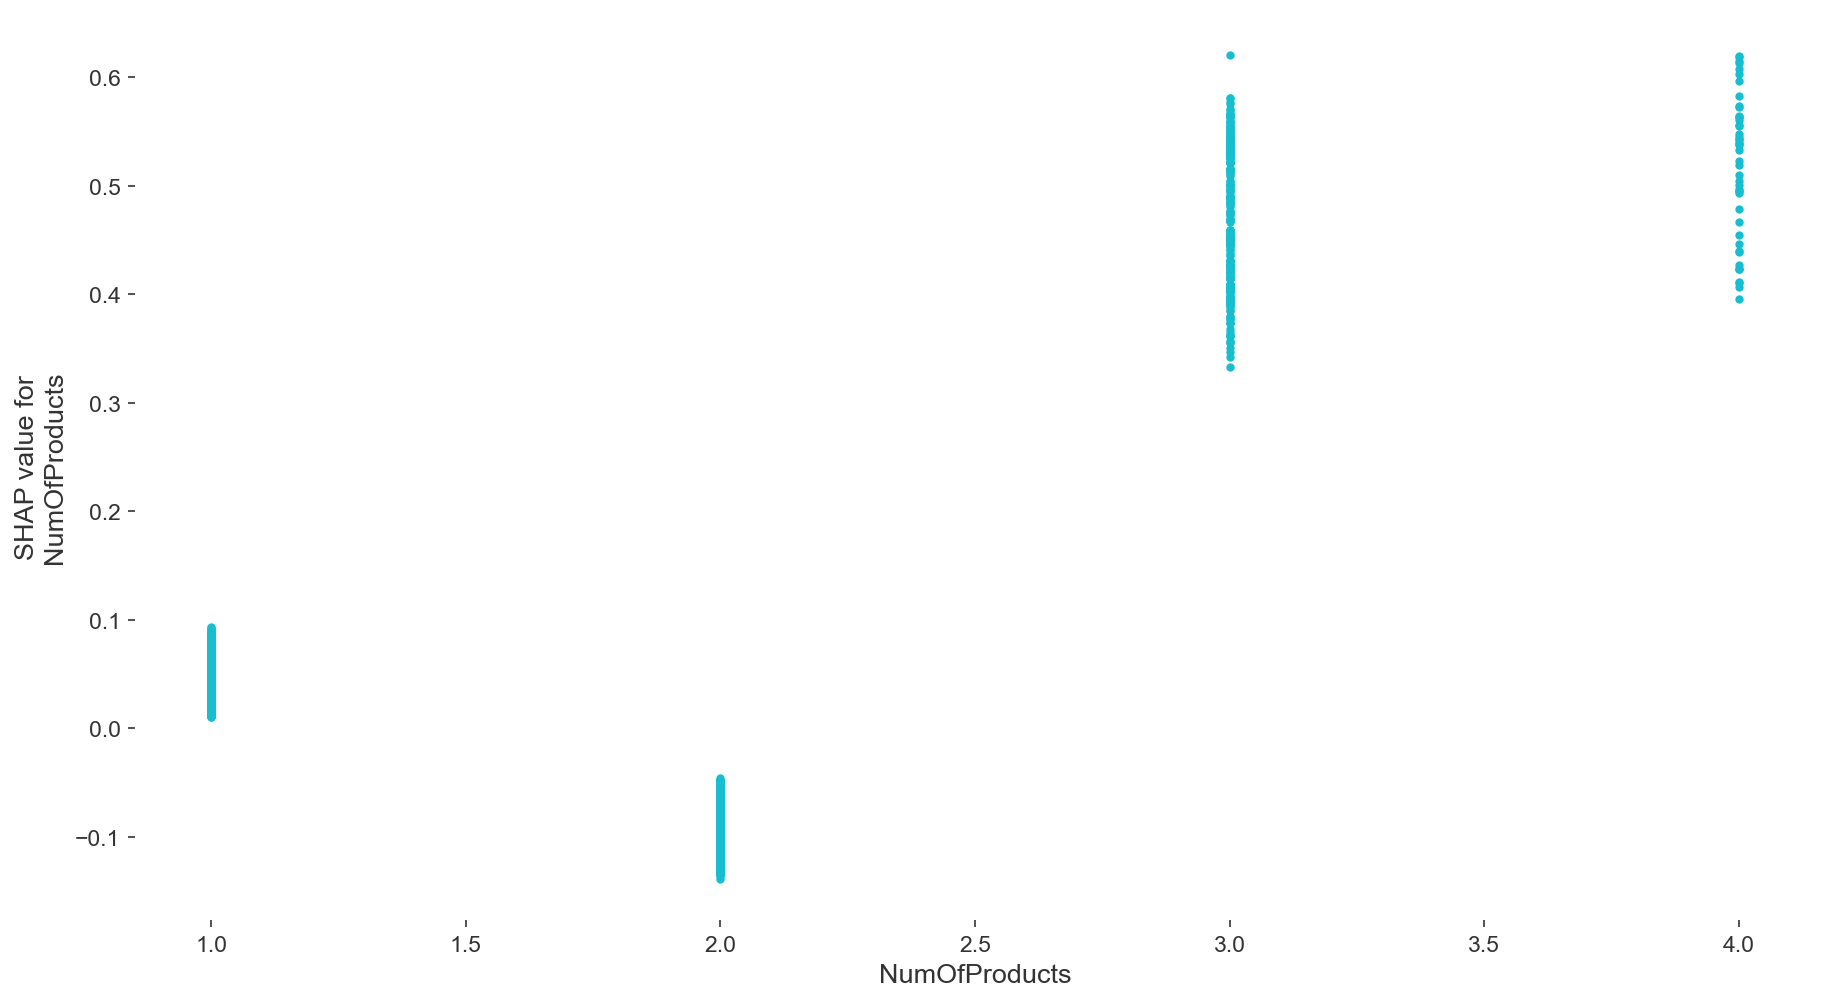

In [25]:
shap.dependence_plot('NumOfProducts', shap_values[1], X_train, interaction_index = None, 
                     color = pyintellify.tableau21[5], show = False)
fig = plt.gcf()
fig.set_figheight(8)
fig.set_figwidth(14)
ax = plt.gca()
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

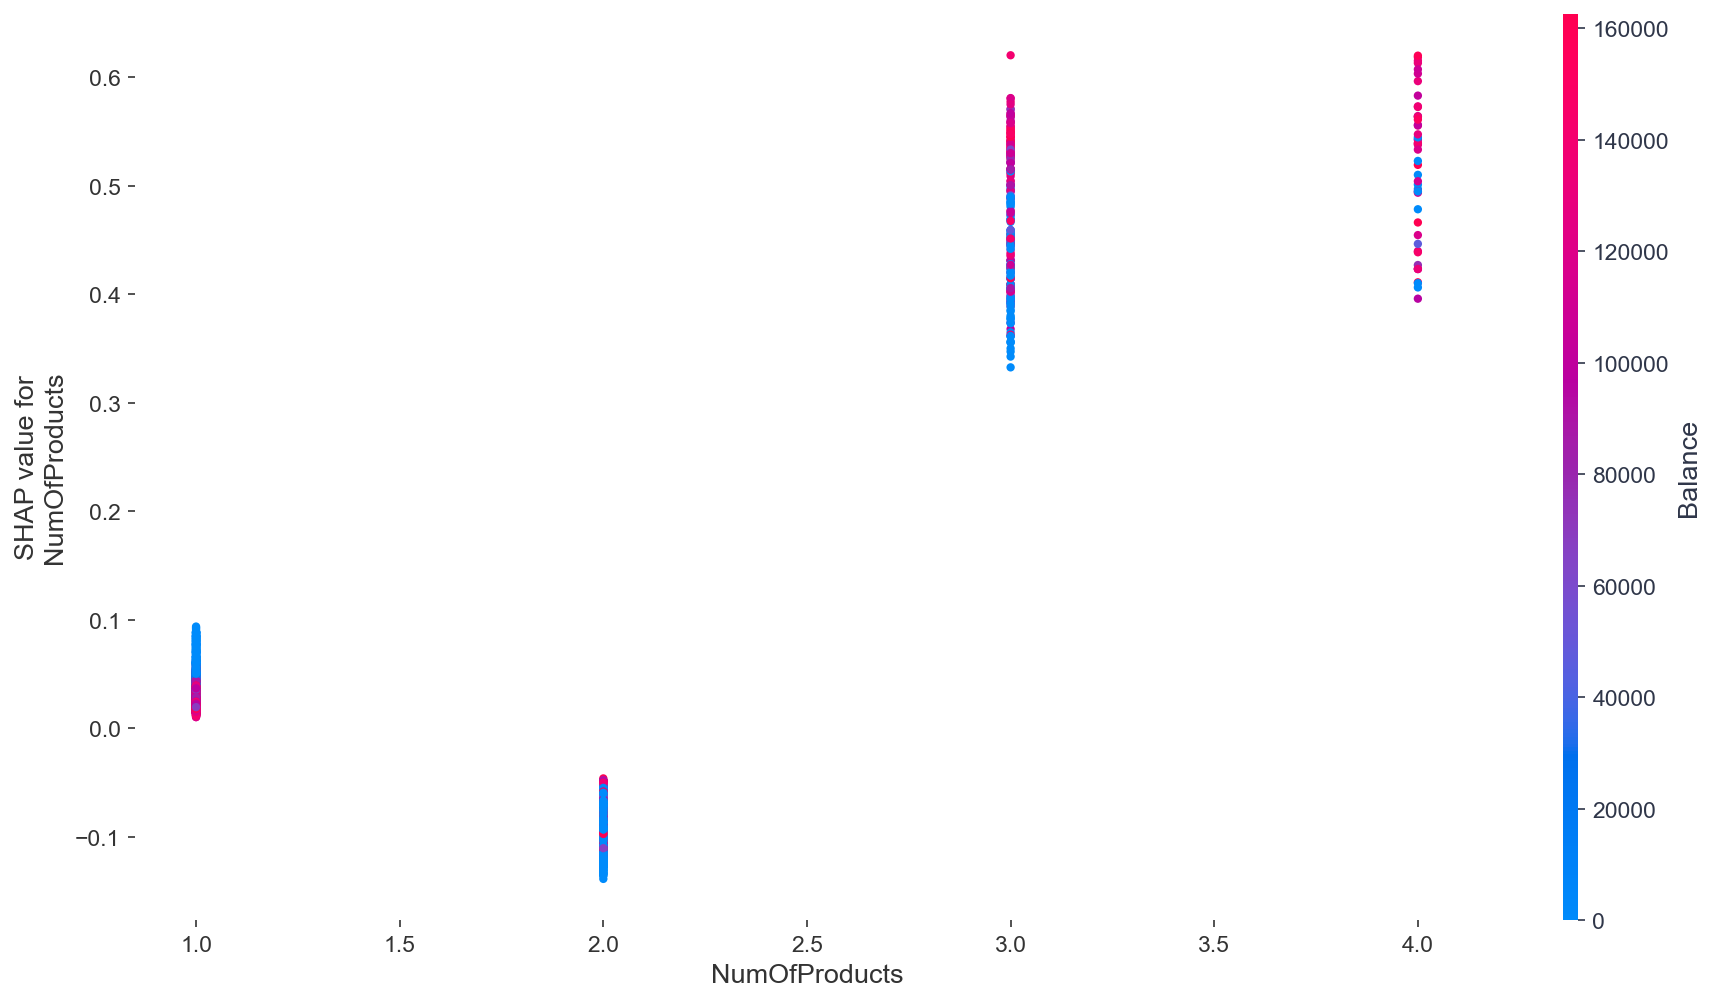

In [26]:
shap.dependence_plot('NumOfProducts', shap_values[1], X_train, 
                     color = pyintellify.tableau21[5], show = False)
fig = plt.gcf()
fig.set_figheight(8)
fig.set_figwidth(14)
ax = plt.gca()
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

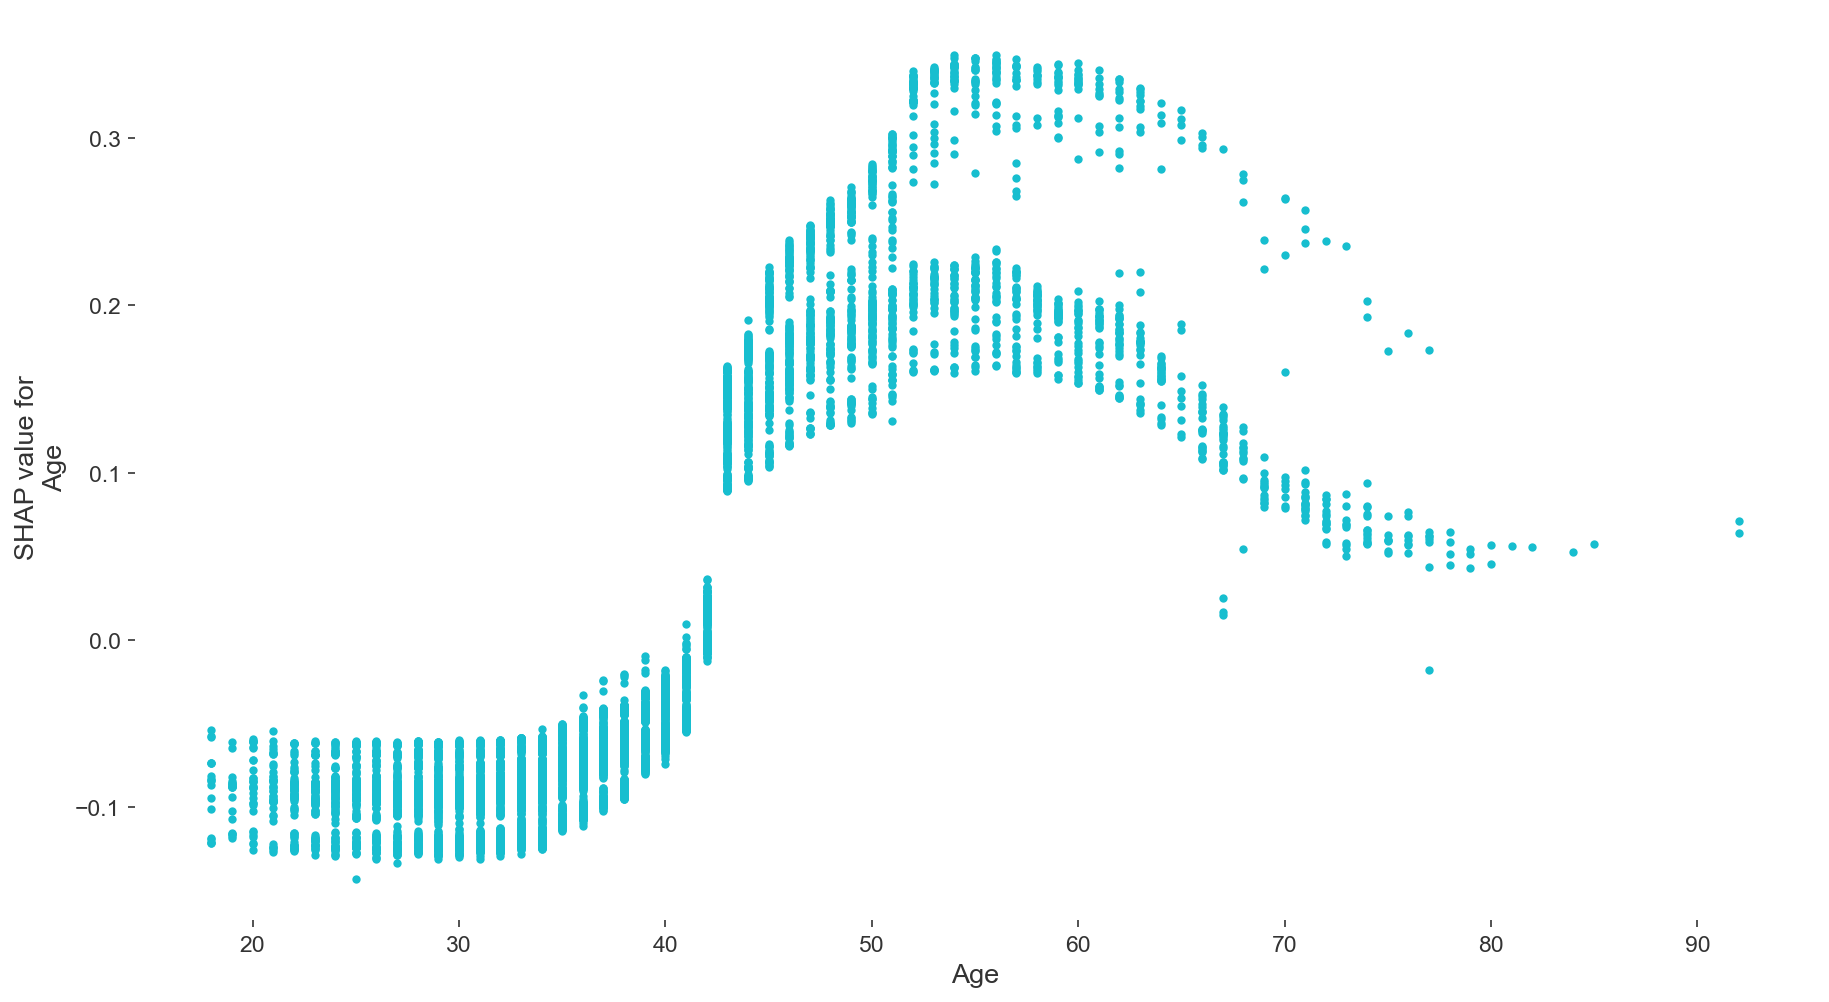

In [27]:
shap.dependence_plot('Age', shap_values[1], X_train, interaction_index = None,
                     color = pyintellify.tableau21[5], show = False)
fig = plt.gcf()
fig.set_figheight(8)
fig.set_figwidth(14)
ax = plt.gca()
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

In [28]:
shap.initjs()

In [29]:
shap.force_plot(explainer.expected_value[1], shap_values[1][10], X_train.iloc[10])

In [30]:
clf.predict_proba(X_train.iloc[10:11])

array([[0.73861012, 0.26138988]])

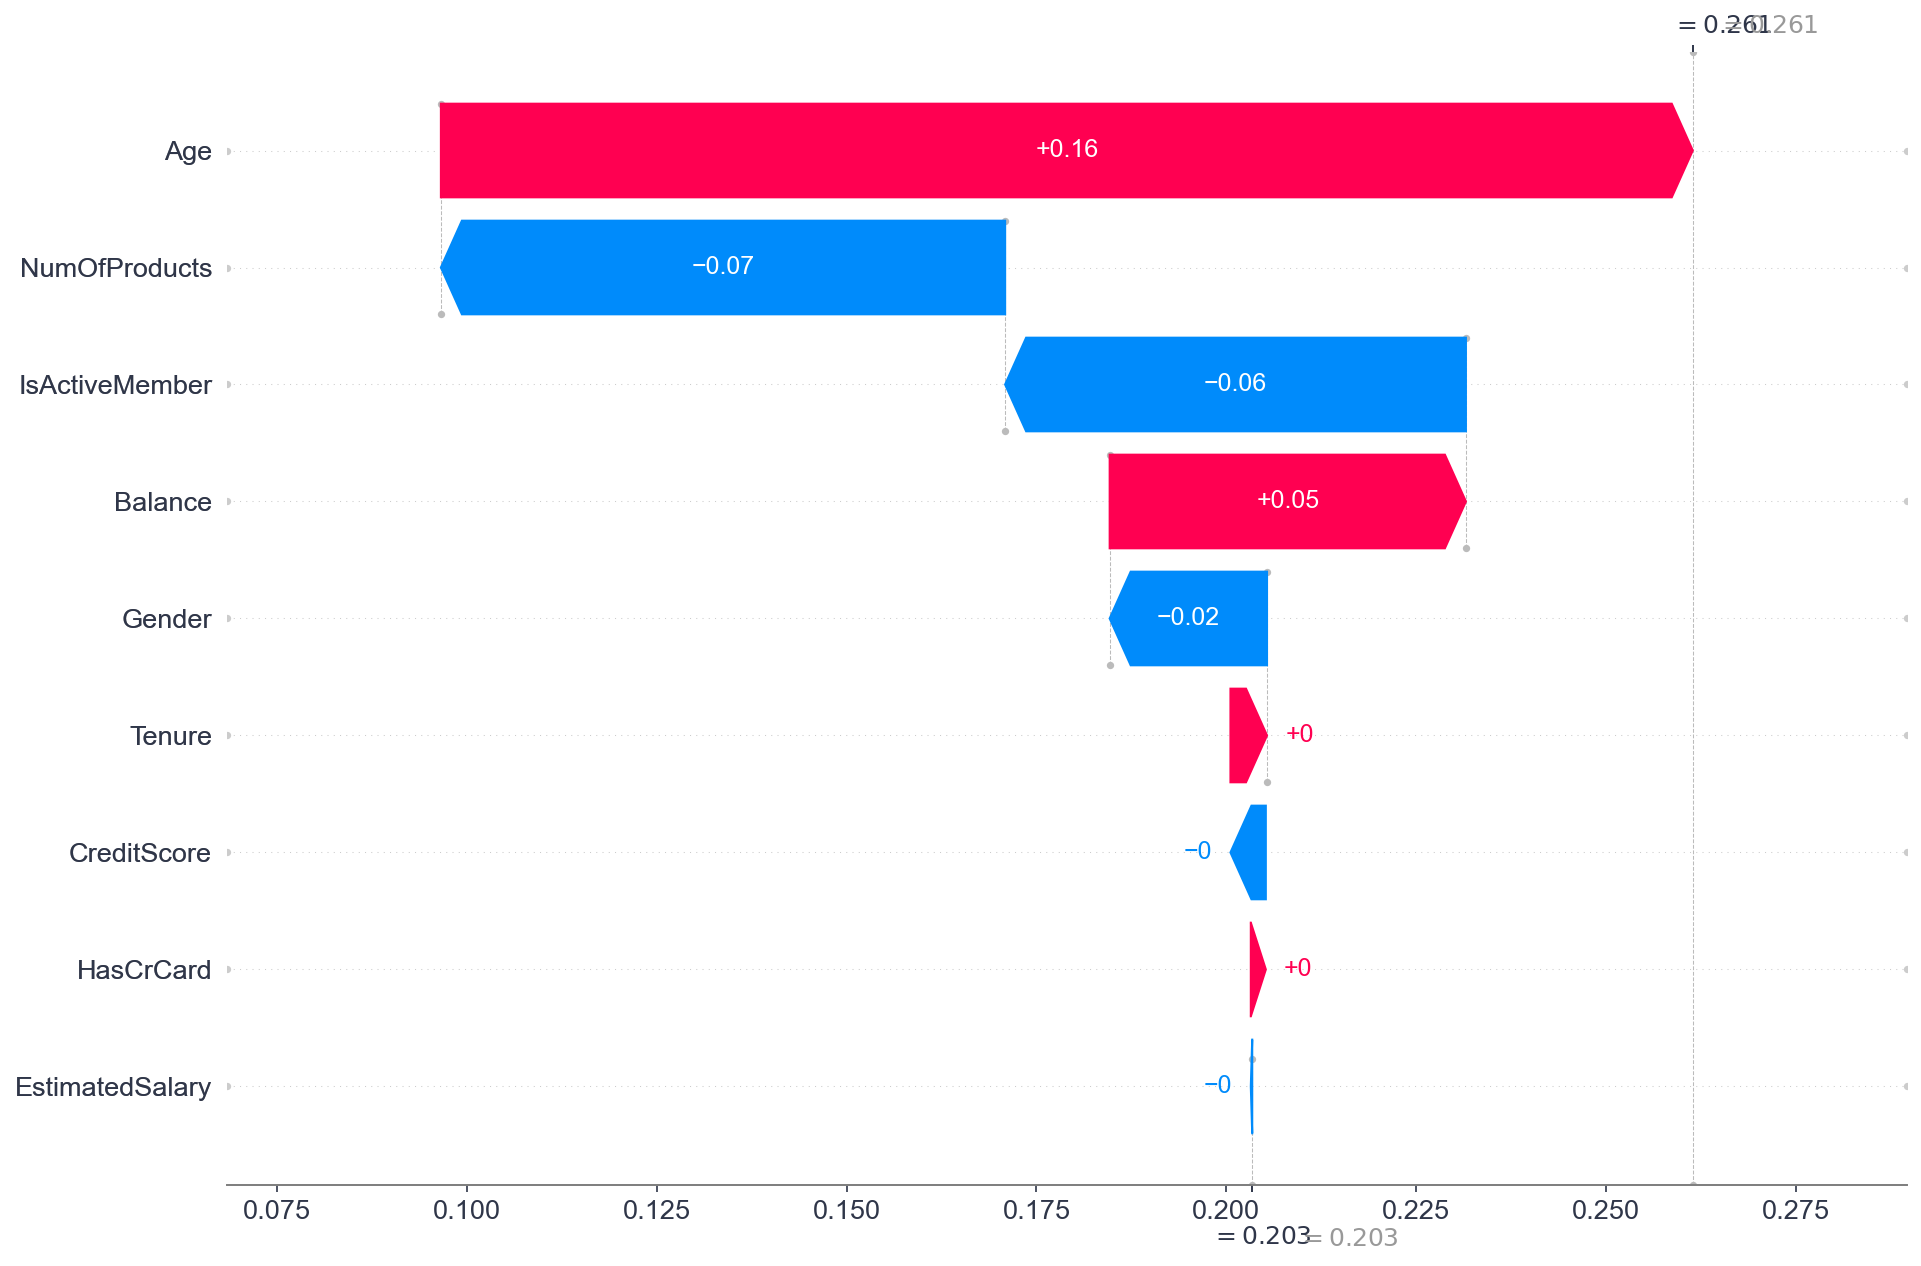

In [31]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1], shap_values[1][10], show = False, feature_names = model_features)
fig = plt.gcf()
fig.set_figheight(10)
fig.set_figwidth(14)
ax = plt.gca()